In [1]:
#https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#1introduction
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

In [2]:
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [4]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to C:\Users\Buket
[nltk_data]     Fildisi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
stop_words.extend(['greenstoneplus','Source','Resources','Links'])

In [6]:
df= pd.read_excel('C:/Users/Buket Fildisi/Desktop/BCU/Dissertation/DEV/DATA/LinkedInParagraph.xlsx')
df.head()

Unnamed: 0                                            Context
0           0  SBTi recently published its fourth report titl...
1           1  Greenstone has curated an article that capture...
2           2  Established in 2014, The Science Based Targets...
3           3  SBTi prioritises emission reduction, offering ...
4           4  "SBTi Monitoring Report 2022 - Looking back at...

In [7]:
df=df.drop(df.columns[0], axis=1)
df.head()

Context
0  SBTi recently published its fourth report titl...
1  Greenstone has curated an article that capture...
2  Established in 2014, The Science Based Targets...
3  SBTi prioritises emission reduction, offering ...
4  "SBTi Monitoring Report 2022 - Looking back at...

In [8]:
df['Context']=df['Context'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in (stop_words)]))
df

Context
0     SBTi recently published fourth report titled "...
1     Greenstone curated article captures key insigh...
2     Established 2014, Science Based Targets Initia...
3     SBTi prioritises emission reduction, offering ...
4     "SBTi Monitoring Report 2022 - Looking back 20...
...                                                 ...
1548  Greenstone Gold Accredited CDP software partne...
1549         Using Greenstone’s software companies can:
1550  Define bespoke question sets range reporting f...
1551  well software, Greenstone provides clients sup...
1552                                                   

[1553 rows x 1 columns]

In [10]:
import nltk
from nltk.tokenize import sent_tokenize

# Download the NLTK sentence tokenizer data
nltk.download('punkt')

def get_sentences(paragraph):
    # Tokenize the paragraph into sentences
    sentences = sent_tokenize(paragraph)
    return sentences

[nltk_data] Downloading package punkt to C:\Users\Buket
[nltk_data]     Fildisi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [19]:
df_list=df["Context"].values.tolist()
df_list

['SBTi recently published fourth report titled "SBTi Monitoring Report 2022 - Looking back 2022 moving forward 2023 beyond". comprehensive report delves worldwide advancements science-based targets reveals remarkable ongoing surge adoption science-targets companies financial institutions. trend persists despite escalating challenges prevalent global stage.',
 'Greenstone curated article captures key insights report.',
 'Established 2014, Science Based Targets Initiative (SBTi) collaboration among organisations including CDP, United Nations Global Compact, World Resources Institute (WRI), World Wide Fund Nature (WWF), Mean Business Coalition. assists global companies financial institutions setting science-based GHG emissions reduction targets, striving ambitious corporate climate action. SBTi mission involves aligning businesses climate science, cutting emissions, contributing goal limiting global warming 1.5°C.',
 'SBTi prioritises emission reduction, offering sector-specific guidance 

In [20]:
df_list=get_sentences(str(df_list))
df_list

['[\'SBTi recently published fourth report titled "SBTi Monitoring Report 2022 - Looking back 2022 moving forward 2023 beyond".',
 'comprehensive report delves worldwide advancements science-based targets reveals remarkable ongoing surge adoption science-targets companies financial institutions.',
 'trend persists despite escalating challenges prevalent global stage.',
 "', 'Greenstone curated article captures key insights report.",
 "', 'Established 2014, Science Based Targets Initiative (SBTi) collaboration among organisations including CDP, United Nations Global Compact, World Resources Institute (WRI), World Wide Fund Nature (WWF), Mean Business Coalition.",
 'assists global companies financial institutions setting science-based GHG emissions reduction targets, striving ambitious corporate climate action.',
 'SBTi mission involves aligning businesses climate science, cutting emissions, contributing goal limiting global warming 1.5°C.',
 "', 'SBTi prioritises emission reduction, off

In [21]:
import string
import re
def text_clean_1(text):
    text = text.lower()
    text= text.replace(".  ",".");
    text= text.replace("'  ',","");
    text= text.replace(" '","'");
    text= text.replace("  ","");
    text= text.replace("▶ ","");
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    return text

In [22]:
text_clean_1(df_list[3])

'greenstone curated article captures key insights report'

In [23]:
len(df_list)

2485

In [24]:
doc=[]
for i in range(len(df_list)):
    doc.append(text_clean_1(df_list[i]))
doc


['sbti recently published fourth report titled sbti monitoring report 2022  looking back 2022 moving forward 2023 beyond',
 'comprehensive report delves worldwide advancements sciencebased targets reveals remarkable ongoing surge adoption sciencetargets companies financial institutions',
 'trend persists despite escalating challenges prevalent global stage',
 'greenstone curated article captures key insights report',
 'established 2014 science based targets initiative sbti collaboration among organisations including cdp united nations global compact world resources institute wri world wide fund nature wwf mean business coalition',
 'assists global companies financial institutions setting sciencebased ghg emissions reduction targets striving ambitious corporate climate action',
 'sbti mission involves aligning businesses climate science cutting emissions contributing goal limiting global warming 15°c',
 'sbti prioritises emission reduction offering sectorspecific guidance highemission i

In [25]:
type(doc)

list

In [26]:
doc[1]

'comprehensive report delves worldwide advancements sciencebased targets reveals remarkable ongoing surge adoption sciencetargets companies financial institutions'

In [27]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  
        # deacc=True removes punctuations

data_words = list(sent_to_words(doc))

print(data_words[:1])

[['sbti', 'recently', 'published', 'fourth', 'report', 'titled', 'sbti', 'monitoring', 'report', 'looking', 'back', 'moving', 'forward', 'beyond']]


In [28]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(doc, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[doc], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['sbti', 'recently', 'published', 'fourth', 'report', 'titled', 'sbti', 'monitoring', 'report', 'looking', 'back', 'moving', 'forward', 'beyond']


In [29]:
# Define functions for bigrams, trigrams and lemmatization
import io
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [30]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load("en_core_web_sm")

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['recently', 'publish', 'fourth', 'report', 'title', 'sbti', 'monitoring', 'report', 'look', 'back', 'move', 'forward']]


In [31]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 1), (10, 1)]]


In [32]:
id2word[0]

'back'

In [33]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('back', 1),
  ('forward', 1),
  ('fourth', 1),
  ('look', 1),
  ('monitoring', 1),
  ('move', 1),
  ('publish', 1),
  ('recently', 1),
  ('report', 2),
  ('sbti', 1),
  ('title', 1)]]

In [58]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=26,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [59]:
# Print the Keyword in the 10 topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(12, '0.000*"solar" + 0.000*"sheet" + 0.000*"wind" + 0.000*"usesmortgage" + 0.000*"unlisted" + 0.000*"composition" + 0.000*"propertymotor" + 0.000*"refinance" + 0.000*"proceed" + 0.000*"residential"'), (20, '0.000*"solar" + 0.000*"sheet" + 0.000*"wind" + 0.000*"usesmortgage" + 0.000*"unlisted" + 0.000*"composition" + 0.000*"propertymotor" + 0.000*"refinance" + 0.000*"proceed" + 0.000*"residential"'), (6, '0.000*"solar" + 0.000*"sheet" + 0.000*"wind" + 0.000*"usesmortgage" + 0.000*"unlisted" + 0.000*"composition" + 0.000*"propertymotor" + 0.000*"refinance" + 0.000*"proceed" + 0.000*"residential"'), (1, '0.237*"material" + 0.114*"number" + 0.110*"high" + 0.064*"list" + 0.059*"compare" + 0.039*"growth" + 0.008*"index" + 0.000*"materiality" + 0.000*"financially" + 0.000*"water"'), (17, '0.308*"make" + 0.138*"aim" + 0.061*"ambitious" + 0.033*"necessary" + 0.018*"combine" + 0.014*"previous" + 0.010*"figure" + 0.008*"adoption" + 0.002*"transformation" + 0.000*"module"'), (15, '0.129*"sector"

In [60]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -17.443591842398128

Coherence Score:  0.41122401272329756


In [37]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\Users\Buket Fildisi\anaconda3\Lib\site-packages\pyLDAvis\_prepare.py:232: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
13    -0.291361 -0.149154       1        1  16.848623
4     -0.258958  0.375989       2        1  15.844696
2     -0.143820 -0.099175       3        1  10.258534
9     -0.178445 -0.188873       4        1   7.779178
0     -0.099935 -0.006184       5        1   6.758730
3     -0.050654 -0.000416       6        1   5.767232
6      0.002168  0.002516       7        1   4.677039
5      0.040630  0.004244       8        1   4.000919
19     0.044600  0.004351       9        1   3.436007
18     0.047686  0.004438      10        1   3.396213
11     0.050909  0.004522      11        1   3.058326
14     0.060126  0.004729      12        1   2.850019
7      0.074849  0.005079      13        1   2.595155
16     0.093312  0.005412      14        1   2.404274
15     0.073175  0.005085      15        1   2.384771
12     0.090159  0.005309      16        1   2.165608
10     0.102147  0.005459      17        1   2.021967
1      0.110785  0.005574      18        1   1.696063
8      0.103550  0.005471      19        1   1.374536
17     0.129078  0.005623      20        1   0.682110, topic_info=          Term         Freq        Total Category  logprob  loglift
13     company  1076.000000  1076.000000  Default  30.0000  30.0000
109      datum   646.000000   646.000000  Default  29.0000  29.0000
59    emission   721.000000   721.000000  Default  28.0000  28.0000
156   supplier   564.000000   564.000000  Default  27.0000  27.0000
8       report   860.000000   860.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
573   standard     0.035423     1.357111  Topic20  -8.7327   1.3420
757       step     0.035417     1.356164  Topic20  -8.7329   1.3425
690   activity     0.035417     1.356153  Topic20  -8.7329   1.3425
610     reduce     0.035418     1.356366  Topic20  -8.7328   1.3424
1060     drive     0.035417     1.356138  Topic20  -8.7329   1.3425

[794 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
257       6  0.983989      access
115      10  0.875894  accessible
145      15  0.944793  accounting
410       4  0.891037    accredit
313      13  0.852089    accuracy
...     ...       ...         ...
52       14  0.930327        wide
443       3  0.982704        work
89        3  0.977331       world
25        4  0.934546   worldwide
106      10  0.991169        year

[360 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 5, 3, 10, 1, 4, 7, 6, 20, 19, 12, 15, 8, 17, 16, 13, 11, 2, 9, 18])

In [133]:
#Building LDA Mallet Model
#gensim version 4.3.0
#If your work depends on any of the modules below, feel free to copy it out of Gensim 3.8.3 (the last release where they appear), and extend & maintain the wrapper yourself.
#import os
#from gensim.models.wrappers import LdaMallet
#mallet_path = 'C:/Users/Buket Fildisi/mallet-2.0.8/bin/mallet' # update this path
#ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [134]:
#How to find optimal number of topic


In [38]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics)
        #gensim.models.wrappers.LdaMallet( corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [39]:
# Takes a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

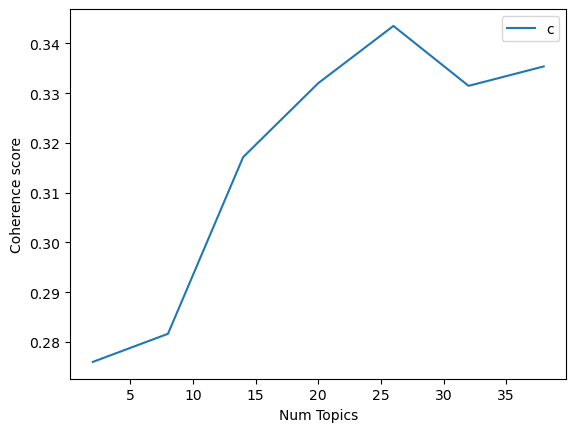

In [40]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [41]:
#If the coherence score seems to keep increasing, 
#it may make better sense to pick the model that gave the highest CV before flattening out.
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.276
Num Topics = 8  has Coherence Value of 0.2816
Num Topics = 14  has Coherence Value of 0.3171
Num Topics = 20  has Coherence Value of 0.332
Num Topics = 26  has Coherence Value of 0.3435
Num Topics = 32  has Coherence Value of 0.3315
Num Topics = 38  has Coherence Value of 0.3354


In [42]:
# Select the model and print the topics
optimal_model = model_list[6]
model_topics = optimal_model.show_topics(formatted=False)
print(optimal_model.print_topics(num_words=10))

[(11, '0.024*"scope" + 0.022*"datum" + 0.020*"shock" + 0.018*"financial" + 0.017*"saving" + 0.017*"eg" + 0.017*"change" + 0.016*"climate" + 0.016*"emission" + 0.014*"risk"'), (36, '0.046*"supplier" + 0.024*"company" + 0.018*"assessment" + 0.016*"materiality" + 0.013*"organisation" + 0.011*"external" + 0.011*"place" + 0.010*"well" + 0.010*"high" + 0.010*"forest"'), (3, '0.053*"questionnaire" + 0.025*"stress" + 0.022*"question" + 0.021*"module" + 0.019*"series" + 0.016*"resource" + 0.015*"part" + 0.015*"external" + 0.014*"company" + 0.013*"cover"'), (30, '0.034*"datum" + 0.025*"private" + 0.024*"esg" + 0.018*"company" + 0.018*"lack" + 0.018*"need" + 0.018*"good" + 0.017*"questionnaire" + 0.016*"regulation" + 0.014*"get"'), (4, '0.024*"report" + 0.022*"disclosure" + 0.018*"submit" + 0.017*"risk" + 0.016*"target" + 0.014*"cdp" + 0.013*"expect" + 0.013*"standard" + 0.013*"deadline" + 0.013*"reporting"'), (24, '0.020*"business" + 0.017*"datum" + 0.017*"report" + 0.017*"enterprise" + 0.017*"c

In [43]:
visOpt = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
visOpt
#we can see the optimal topic number 

C:\Users\Buket Fildisi\anaconda3\Lib\site-packages\pyLDAvis\_prepare.py:232: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
5     -0.065096 -0.051331       1        1  6.960873
18     0.044857  0.049030       2        1  4.368087
26     0.121725 -0.094865       3        1  4.263811
16     0.059371  0.068992       4        1  3.449191
22    -0.057262 -0.000843       5        1  3.429008
37    -0.065465 -0.021513       6        1  3.369185
4     -0.042509  0.024117       7        1  3.368489
12     0.074478  0.040277       8        1  3.351831
15    -0.108662 -0.038023       9        1  3.296963
36     0.026409  0.007803      10        1  3.111226
28    -0.015769  0.047541      11        1  3.043332
10     0.111070 -0.111585      12        1  2.954726
7      0.069158 -0.002812      13        1  2.635846
25     0.088893  0.201046      14        1  2.521882
11     0.038918  0.005478      15        1  2.485077
34    -0.009119 -0.038423      16        1  2.482910
31     0.156434 -0.020204      17        1  2.470514
21    -0.129756  0.114993      18        1  2.469605
19     0.072073  0.030895      19        1  2.454245
33    -0.016068 -0.019101      20        1  2.446321
9      0.101035 -0.056052      21        1  2.445748
35     0.023839  0.120918      22        1  2.375727
8     -0.013161 -0.065415      23        1  2.370201
0     -0.021510  0.051854      24        1  2.342374
27    -0.031053 -0.062097      25        1  2.304644
24    -0.059794 -0.057446      26        1  2.299441
29    -0.097643  0.073501      27        1  2.229713
20    -0.032822 -0.055649      28        1  2.199310
30    -0.133318 -0.119874      29        1  1.912342
6     -0.023846 -0.040050      30        1  1.836847
1     -0.027551  0.026802      31        1  1.794650
14     0.021751 -0.028963      32        1  1.766247
23     0.080980 -0.017534      33        1  1.672471
13    -0.026695  0.025994      34        1  1.630003
2     -0.057389  0.026236      35        1  1.545243
3     -0.106338  0.030930      36        1  1.473241
32     0.026916 -0.005666      37        1  1.441018
17     0.022920 -0.038960      38        1  1.427654, topic_info=              Term        Freq       Total Category  logprob  loglift
59        emission  540.000000  540.000000  Default  30.0000  30.0000
144          scope  323.000000  323.000000  Default  29.0000  29.0000
478  questionnaire  105.000000  105.000000  Default  28.0000  28.0000
665          score   81.000000   81.000000  Default  27.0000  27.0000
347       investor  198.000000  198.000000  Default  26.0000  26.0000
..             ...         ...         ...      ...      ...      ...
400           need    4.105648  146.871292  Topic38  -4.7185   0.6719
550         metric    3.746914   59.421734  Topic38  -4.8100   1.4854
460         factor    3.587324   54.325225  Topic38  -4.8535   1.5316
522          issue    3.518774   74.777796  Topic38  -4.8728   1.1927
8           report    3.333065  502.398171  Topic38  -4.9270  -0.7664

[2220 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
835       1  0.100711     ability
835       2  0.201421     ability
835       3  0.302132     ability
835      19  0.100711     ability
835      20  0.100711     ability
...     ...       ...         ...
106      32  0.068789        year
106      37  0.019654        year
106      38  0.019654        year
132      38  0.639475  yearonyear
961       5  0.368146         yet

[6458 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 19, 27, 17, 23, 38, 5, 13, 16, 37, 29, 11, 8, 26, 12, 35, 32, 22, 20, 34, 10, 36, 9, 1, 28, 25, 30, 21, 31, 7, 2, 15, 24, 14, 3, 4, 33, 18])

In [44]:
#to find dominant topic in each doc
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_lemmatized):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

C:\Users\Buket Fildisi\AppData\Local\Temp\ipykernel_5428\1719133165.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
C:\Users\Buket Fildisi\AppData\Local\Temp\ipykernel_5428\1719133165.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
C:\Users\Buket Fildisi\AppData\Local\Temp\ipykernel_5428\1719133165.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0              16              0.7265   
1            1              27              0.4409   
2            2              18              0.8782   
3            3               5              0.4904   
4            4               7              0.8276   
5            5              26              0.3510   
6            6               7              0.4135   
7            7               8              0.4741   
8            8              32              0.8438   
9            9              12              0.8609   

                                            Keywords  \
0  climate, company, business, impact, change, re...   
1  investor, esg, company, private, report, expec...   
2  supplier, supply, management, risk, chain, pra...   
3  report, datum, software, enable, sustainabilit...   
4  business, emission, organisation, esg, governa...   
5  emission, scope, report, company, target, carb...   
6  business, emission, organisation, esg, governa...   
7  report, emission, company, webinar, update, do...   
8  business, identify, make, different, coverage,...   
9  company, emission, impact, climate, include, c...   

                                                Text  
0  [recently, publish, fourth, report, title, sbt...  
1  [comprehensive, report, delve, worldwide, adva...  
2  [trend, persist, escalate, challenge, prevalen...  
3  [greenstone, curate, article, capture, key, in...  
4  [establish, science, base, target, initiative,...  
5  [assist, global, company, financial, instituti...  
6  [sbti, mission, involve, align, business, clim...  
7  [sbti, prioritise, emission, reduction, offer,...  
8  [approach, aim, make, ambitious, climate, acti...  
9  [include, collaboration, large, company, suppl...

In [45]:
df_dominant_topic

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0               0              16              0.7265   
1               1              27              0.4409   
2               2              18              0.8782   
3               3               5              0.4904   
4               4               7              0.8276   
...           ...             ...                 ...   
2480         2480              24              0.9351   
2481         2481              11              0.9459   
2482         2482               5              0.6274   
2483         2483              20              0.9536   
2484         2484               0              0.0263   

                                               Keywords  \
0     climate, company, business, impact, change, re...   
1     investor, esg, company, private, report, expec...   
2     supplier, supply, management, risk, chain, pra...   
3     report, datum, software, enable, sustainabilit...   
4     business, emission, organisation, esg, governa...   
...                                                 ...   
2480  business, datum, report, enterprise, company, ...   
2481  scope, datum, shock, financial, saving, eg, ch...   
2482  report, datum, software, enable, sustainabilit...   
2483  deampi, company, client, scope, cdp, diverse, ...   
2484  diversity, deampi, provide, esg, reporting, hu...   

                                                   Text  
0     [recently, publish, fourth, report, title, sbt...  
1     [comprehensive, report, delve, worldwide, adva...  
2     [trend, persist, escalate, challenge, prevalen...  
3     [greenstone, curate, article, capture, key, in...  
4     [establish, science, base, target, initiative,...  
...                                                 ...  
2480  [global, sustainability, management, software,...  
2481  [include, protocol, align, datum, collection, ...  
2482  [use, greenstone, software, company, candefine...  
2483  [indepth, knowledge, cdp, reporting, system, t...  
2484                                                 []  

[2485 rows x 5 columns]

In [46]:
df_dominant_topic.to_excel('C:/Users/Buket Fildisi/Desktop/BCU/Dissertation/DEV/DATA/LinkedIn_sentences.xlsx')

In [47]:
#Topic Distribution 
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

Dominant_Topic                                     Topic_Keywords  \
0                 16  climate, company, business, impact, change, re...   
1                 27  investor, esg, company, private, report, expec...   
2                 18  supplier, supply, management, risk, chain, pra...   
3                  5  report, datum, software, enable, sustainabilit...   
4                  7  business, emission, organisation, esg, governa...   
...              ...                                                ...   
2480              24  business, datum, report, enterprise, company, ...   
2481              11  scope, datum, shock, financial, saving, eg, ch...   
2482               5  report, datum, software, enable, sustainabilit...   
2483              20  deampi, company, client, scope, cdp, diverse, ...   
2484               0  diversity, deampi, provide, esg, reporting, hu...   

      Num_Documents  Perc_Documents  
0              80.0          0.0322  
1              37.0          0.0149  
2              40.0          0.0161  
3              31.0          0.0125  
4              81.0          0.0326  
...             ...             ...  
2480            NaN             NaN  
2481            NaN             NaN  
2482            NaN             NaN  
2483            NaN             NaN  
2484            NaN             NaN  

[2485 rows x 4 columns]

In [48]:
d = df_dominant_topics['Topic_Keywords'].tolist()
wordclouddeneme= ' '.join(map(str, d)) 
wordclouddeneme

'climate, company, business, impact, change, report, chain, supply, include, energy investor, esg, company, private, report, expect, come, make, supplier, year supplier, supply, management, risk, chain, practice, gather, company, organisation, emission report, datum, software, enable, sustainability, greenstone, use, emission, esg, solution business, emission, organisation, esg, governance, investor, value, sustainability, employee, also emission, scope, report, company, target, carbon, reduction, organisation, datum, chain business, emission, organisation, esg, governance, investor, value, sustainability, employee, also report, emission, company, webinar, update, document, directly, set, global, deadline business, identify, make, different, coverage, sector, accord, immediate, apply, datum company, emission, impact, climate, include, covid, supplier, commonly, tip, change report, emission, company, webinar, update, document, directly, set, global, deadline version, emission, minimum, 

In [49]:
from wordcloud import WordCloud, STOPWORDS

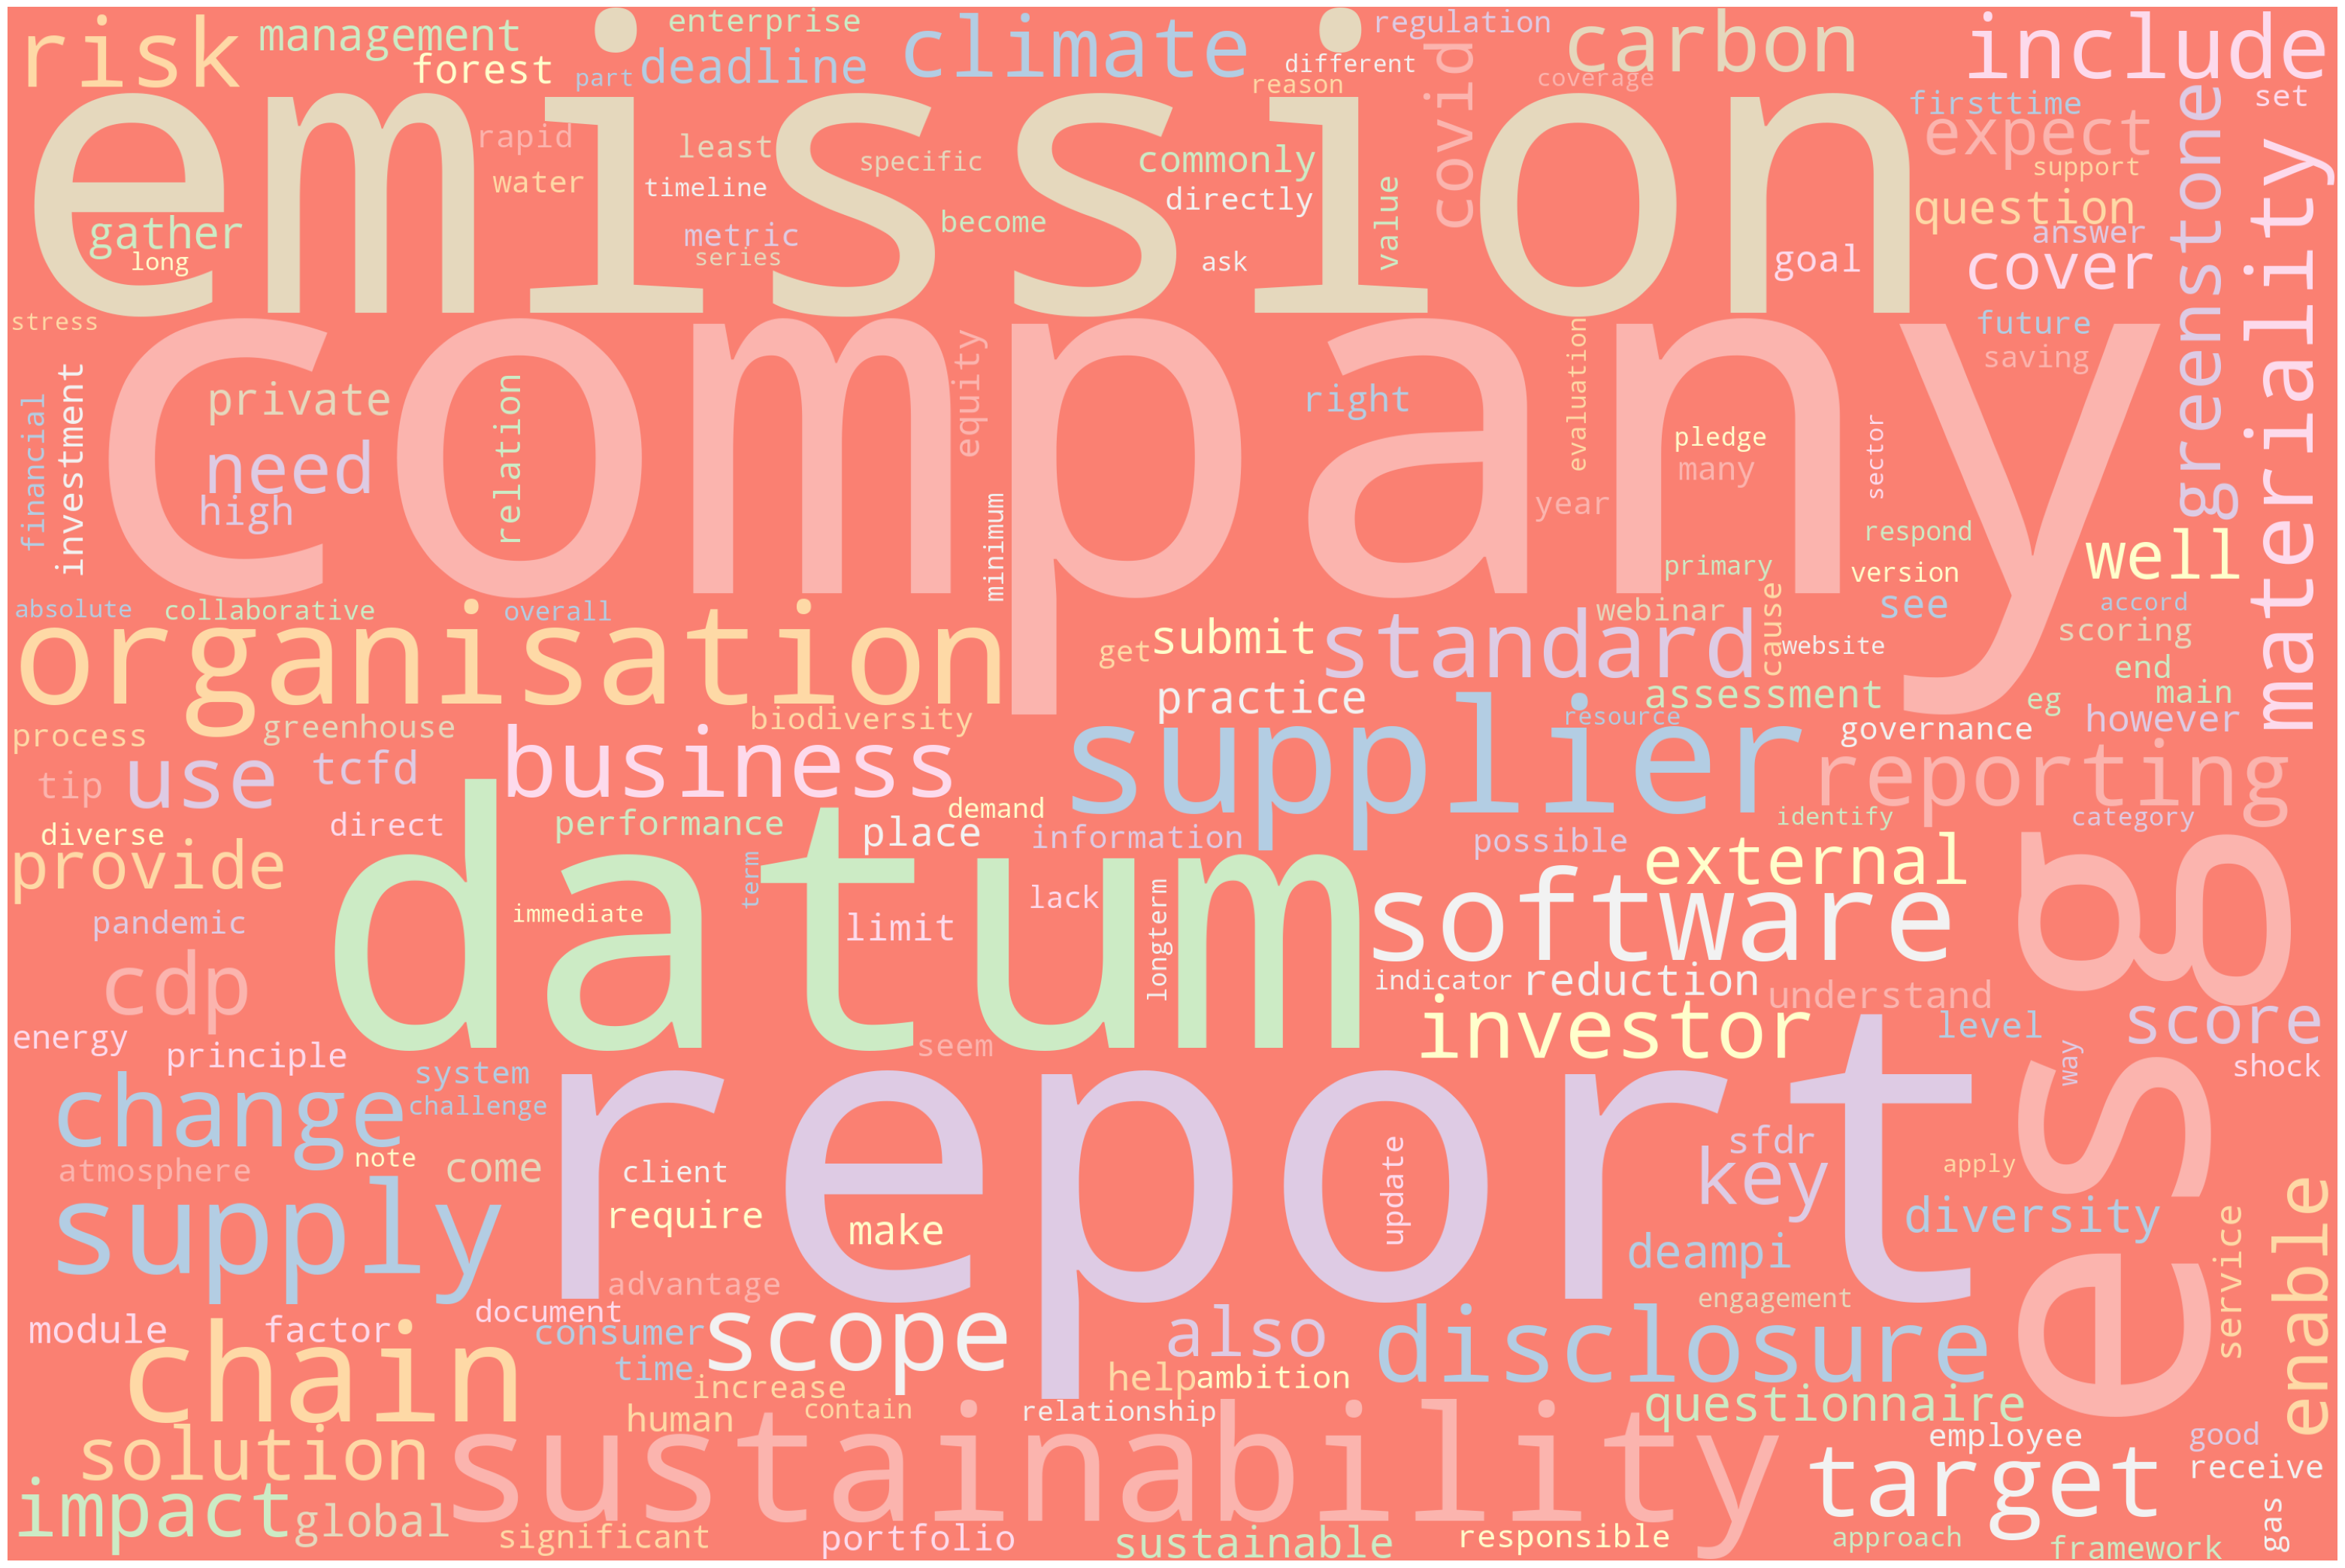

In [50]:
# Import packages
import matplotlib.pyplot as plt
%matplotlib inline
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off")
# Import package

# Generate word cloud
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='salmon', colormap='Pastel1', collocations=False, stopwords = stop_words).generate(wordclouddeneme)
# Plot
plot_cloud(wordcloud)

In [51]:
y=df_dominant_topic['Keywords'].apply(lambda x: x.split(', ') if isinstance(x, str) else [])
print(y)
keywords_list = [keyword for sublist in y for keyword in sublist]
print(keywords_list)
# Count the occurrences of each keyword
keyword_counts = pd.Series(keywords_list).value_counts()
print(keyword_counts)

0       [climate, company, business, impact, change, r...
1       [investor, esg, company, private, report, expe...
2       [supplier, supply, management, risk, chain, pr...
3       [report, datum, software, enable, sustainabili...
4       [business, emission, organisation, esg, govern...
                              ...                        
2480    [business, datum, report, enterprise, company,...
2481    [scope, datum, shock, financial, saving, eg, c...
2482    [report, datum, software, enable, sustainabili...
2483    [deampi, company, client, scope, cdp, diverse,...
2484    [diversity, deampi, provide, esg, reporting, h...
Name: Keywords, Length: 2485, dtype: object
['climate', 'company', 'business', 'impact', 'change', 'report', 'chain', 'supply', 'include', 'energy', 'investor', 'esg', 'company', 'private', 'report', 'expect', 'come', 'make', 'supplier', 'year', 'supplier', 'supply', 'management', 'risk', 'chain', 'practice', 'gather', 'company', 'organisation', 'emission', 'r

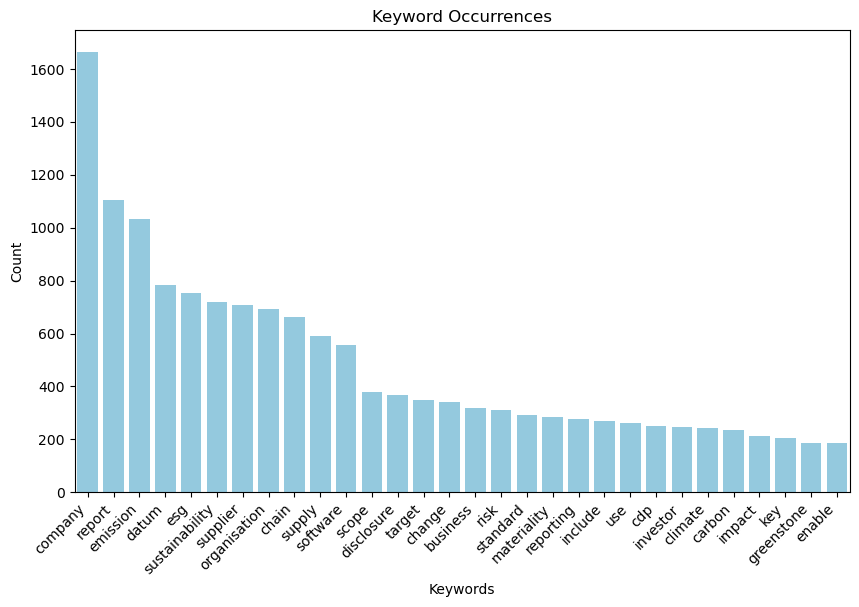

In [61]:
# Create a bar chart using Seaborn
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.barplot(x=keyword_counts[:30].index, y=keyword_counts[:30].values, color='skyblue')
plt.title('Keyword Occurrences')
plt.xlabel('Keywords')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()